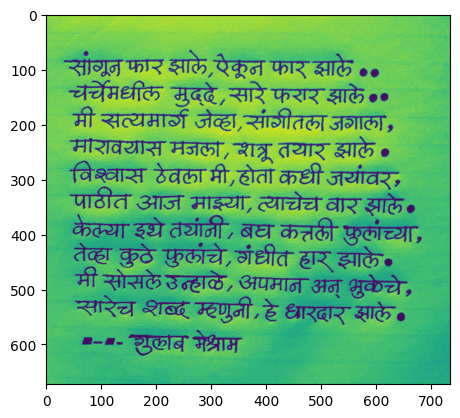

IndexError: list index out of range

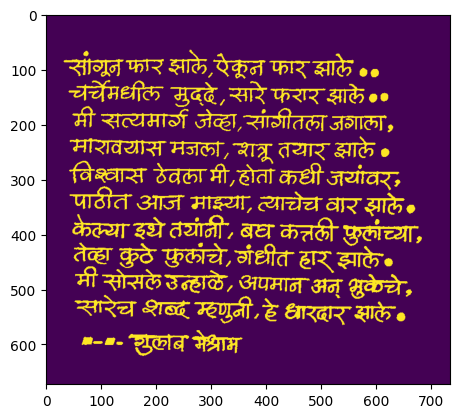

In [1]:
import numpy as np
import cv2
import pytesseract
import pandas as pd

import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray,127,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV)
    plt.imshow(gray)
    plt.show()
    plt.imshow(thresh)
    #plt.show()
    return image, thresh

def detect_table_cells(thresh):

    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    vertical_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    horizontal_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)


    grid = cv2.add(vertical_lines, horizontal_lines)


    contours, _ = cv2.findContours(grid, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cells = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 20 and h > 20:  # Filter small elements
            cells.append((x, y, w, h))
    return sorted(cells, key=lambda c: (c[1], c[0]))  # Sort by row, then column
'''
# Step 3: Extract Text from Cells
def extract_text_from_cells(image, cells):
    text_data = []
    for x, y, w, h in cells:
        roi = image[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, l)  # PSM 6 assumes a uniform block of text
        text_data.append(text.strip())
    return text_data
'''
# Step 3: Extract Text from Cells
def extract_text_from_cells(image, cells):
    text_data = []
    for x, y, w, h in cells:
        roi = image[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, lang='mar')
        print(text)
        text_data.append(text.strip())
    return text_data


def reconstruct_table(text_data, cells):
    rows = []
    current_row = []
    last_y = cells[0][1]

    for i, cell in enumerate(cells):
        x, y, w, h = cell
        if abs(y - last_y) > 10:  # New row detected
            rows.append(current_row)
            current_row = []
            last_y = y
        current_row.append(text_data[i])
    rows.append(current_row)  # Add the last row
    return rows


def process_table(image_path, output_csv="output_table.csv"):
    image, thresh = preprocess_image(image_path)
    cells = detect_table_cells(thresh)
    text_data = extract_text_from_cells(image, cells)
    table_data = reconstruct_table(text_data, cells)

    max_cols = max(len(row) for row in table_data)
    table_df = pd.DataFrame(table_data, columns=[f"Col {i+1}" for i in range(max_cols)])
    table_df.to_csv(output_csv, index=False)
    
    num_rows = len(table_data)
    print("Number of rows in the table:", num_rows)
    print("Number of columns in the table:", max_cols)
    
    print("Table saved to", output_csv)
    print(table_df)
    
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
process_table("sample049.png")
